In [39]:
import sys, pickle
sys.path.insert(0, "libs")

import networkx as nx
import numpy as np
from scipy.stats import binom as binDist
from scipy.stats import binom as binomialDistribution
from scipy.interpolate import make_interp_spline
from matplotlib import pyplot as plt
from scipy.special import binom

import matplotlib.colors as mcolors
from libs.utils import *

In [3]:
arr = np.zeros(100)
for i in range(100):
    g = nx.gnp_random_graph(10,0.9)
    arr[i] = g.number_of_edges()

print(np.mean(arr))

40.49


In [4]:
def expected_minimum_binomial(m, n, p):
    # Calculate P(X_i >= k) for each k
    prob_x_geq_k = np.array([sum(binDist.pmf(range(k, n+1), n, p)) for k in range(n+1)])

    # Calculate P(Y = k) for each k (Y being the minimum of m draws)
    prob_y_eq_k = np.zeros(n+1)
    for k in range(n+1):
        if k == n:
            prob_y_eq_k[k] = prob_x_geq_k[k] ** m
        else:
            prob_y_eq_k[k] = prob_x_geq_k[k] ** m - prob_x_geq_k[k+1] ** m

    # Calculate the expected value E[Y]
    expected_value_y = np.sum([k * prob_y_eq_k[k] for k in range(n+1)])
    
    return expected_value_y

In [7]:
expected_minimum_binomial(1, 10, 0.3)

2.999999999999998

In [8]:
from itertools import product

In [12]:
for p in product([1,2,3], [2,5,6], [7,7,4]):
    print(p)

(1, 2, 7)
(1, 2, 7)
(1, 2, 4)
(1, 5, 7)
(1, 5, 7)
(1, 5, 4)
(1, 6, 7)
(1, 6, 7)
(1, 6, 4)
(2, 2, 7)
(2, 2, 7)
(2, 2, 4)
(2, 5, 7)
(2, 5, 7)
(2, 5, 4)
(2, 6, 7)
(2, 6, 7)
(2, 6, 4)
(3, 2, 7)
(3, 2, 7)
(3, 2, 4)
(3, 5, 7)
(3, 5, 7)
(3, 5, 4)
(3, 6, 7)
(3, 6, 7)
(3, 6, 4)


In [14]:
new = [[1,-1],[2,-2],[3,-3]]
for p in product(*new):
    print(p)

(1, 2, 3)
(1, 2, -3)
(1, -2, 3)
(1, -2, -3)
(-1, 2, 3)
(-1, 2, -3)
(-1, -2, 3)
(-1, -2, -3)


In [142]:
def plot_binomial_with_truncated_shifted(n, p, i, colors=None, plot=False):

    # set colors
    if colors is None:
        colors = list((mcolors.TABLEAU_COLORS).values())
    
    # Binomial distribution
    x = np.arange(0, n+1)
    binomial_probs = binomialDistribution.pmf(x, n, p)
    if plot: 
        plt.plot(x, binomial_probs, color='gray', lw=0, marker='x')
    
    # Spline interpolation of the binomial distribution
    grid = 1000
    num_points = n*grid
    x_spline = np.linspace(0, n, num_points)  # More points for a smooth spline
    spline = make_interp_spline(x, binomial_probs, k=3)
    binomial_spline = spline(x_spline)

    # normalize a binomial spline
    binomial_spline = binomial_spline/np.sum(binomial_spline)*grid

    # intialize max degrees array
    max_degrees = np.zeros(i)
    
    # remove maximum-degree nodes, one at a time
    for j in range(i):

        if plot:
            plt.plot(x_spline, binomial_spline, label='removed {}'.format(j), color=colors[j%len(colors)])
            
        # find truncation point
        cumulative_spline = np.cumsum(binomial_spline[::-1])[::-1]
        k_star_index = np.where(cumulative_spline <= 1/n*(grid))[0][0]
        k_star = x_spline[k_star_index]
        if plot:
            plt.axvline(x=k_star, color=colors[j%len(colors)], linestyle='--', label=r'$k_j* = {:.3f}$'.format(k_star, j))


        mean_k = np.sum(x_spline*binomial_spline)/grid
        m = mean_k*(n-j)/2
        print('(mean_k, m) = ({:.3f},{:.3f})'.format(mean_k, m))

        # Truncate right at kmax 
        truncated_spline = np.copy(binomial_spline)
        truncated_spline[k_star_index + 1:] = 0  # Truncate at k*
    
        # shift distribution        
        c = ((n-j)*k_star-(n-1-j)*mean_k)/(k_star-mean_k)/binom(n-j,2)
        #c = 
        shifts = c*np.arange(len(truncated_spline))/(grid)
        #print('shufts',shifts)
        x_truncated_spline = x_spline - shifts
    
        # truncate left at zero
        num_negatives = sum(x_truncated_spline < 0)
        x_truncated_spline = x_truncated_spline[num_negatives:]
        truncated_spline[num_negatives] += np.sum(truncated_spline[:num_negatives])/grid
        truncated_spline = truncated_spline[num_negatives:]
   
        # normalize again        
        truncated_spline = truncated_spline /np.sum(truncated_spline)*grid

        x_spline = x_truncated_spline
        binomial_spline = truncated_spline
        print('(max_k, m-max_k, new m) = ({:.3f},{:.3f},{:.3f})'.format(k_star, m-k_star, 
            np.sum(x_spline*binomial_spline)/grid*(n-j)/2))
        max_degrees[j] = k_star

    if plot:
        plt.legend()

    return max_degrees

(mean_k, m) = (4.018,40.184)
(max_k, m-max_k, new m) = (7.116,33.068,33.825)
(mean_k, m) = (3.382,32.134)
(max_k, m-max_k, new m) = (5.686,26.448,26.683)
(mean_k, m) = (2.809,25.279)
(max_k, m-max_k, new m) = (4.569,20.710,20.306)
(mean_k, m) = (2.256,19.178)
(max_k, m-max_k, new m) = (3.588,15.590,14.558)
(mean_k, m) = (1.713,13.701)
(max_k, m-max_k, new m) = (2.677,11.024,9.359)
(mean_k, m) = (1.170,8.774)
(max_k, m-max_k, new m) = (1.804,6.970,4.660)
(mean_k, m) = (0.621,4.349)
(max_k, m-max_k, new m) = (0.948,3.401,0.422)


array([7.11635582, 5.68560747, 4.56884372, 3.58758783, 2.67700102,
       1.80415304, 0.947721  ])

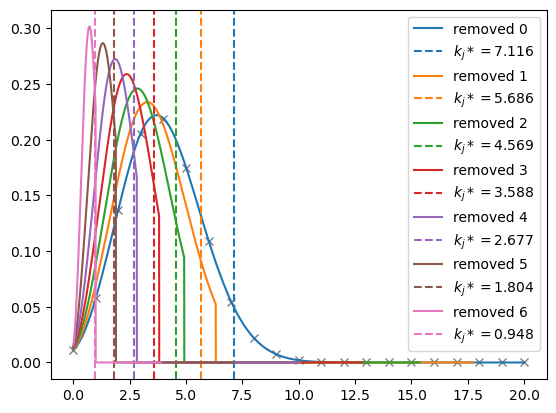

In [147]:
plot_binomial_with_truncated_shifted(20, 0.2, 7, plot=True)

In [ ]:
if False:
    for j in range(i):
        np.cumsum(binomial_spline[::-1])
    
    # Find k* such that the area to the right is 1/n
    cumulative_probs = np.cumsum(binomial_probs[::-1])[::-1]
    k_star_index = np.where(cumulative_probs <= 1/n)[0][0]
    k_star = x[k_star_index]
    
    # Truncate and shift the binomial distribution
    truncated_probs = np.copy(binomial_probs)
    truncated_probs[k_star + 1:] = 0  # Truncate at k*
    
    shift_amount = k_star / (n - 1)
    shifted_probs = np.zeros_like(truncated_probs)
    
    for k in range(n+1):
        new_k = k - int(np.floor(shift_amount))
        if new_k >= 0:
            shifted_probs[new_k] += truncated_probs[k]
        else:
            shifted_probs[0] += truncated_probs[k]  # Reassign probabilities that would go below 0 to k=0

    # Normalize the shifted distribution to ensure it sums to 1
    shifted_probs /= shifted_probs.sum()

    # Spline interpolation of the shifted distribution
    shifted_spline = make_interp_spline(x, shifted_probs, k=3)(x_spline)

    # CDF of the binomial distribution
    binomial_cdf = np.cumsum(binomial_probs)

    # Plotting the distributions, spline, vertical line at k*, and CDF
    plt.figure(figsize=(10, 12))

    # Subplot 1: Original and shifted binomial distributions
    plt.subplot(2, 1, 1)
    plt.plot(x, binomial_probs, 'bo', label=f'Binomial(n={n}, p={p})')
    plt.plot(x_spline, binomial_spline, 'b-', label='Spline interpolation of Binomial')
    plt.plot(x, shifted_probs, 'ro', label='Truncated and Shifted Distribution')
    plt.plot(x_spline, shifted_spline, 'r-', label='Spline of Truncated and Shifted')
    plt.axvline(x=k_star, color='g', linestyle='--', label=f'k* = {k_star}, Area to right = 1/n')
    plt.title(f'Binomial Distribution with Truncated and Shifted Version\nn={n}, p={p}, k* = {k_star}')
    plt.xlabel('k')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)

    # Subplot 2: CDF
    plt.subplot(2, 1, 2)
    plt.step(x, binomial_cdf, where='mid', label='CDF', color='purple')
    plt.axvline(x=k_star, color='g', linestyle='--', label=f'k* = {k_star}')
    plt.title('Cumulative Distribution Function (CDF)')
    plt.xlabel('k')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_binomial_with_truncated_shifted(20, 0.3)  # Example plot for n=20, p=0.3


In [35]:
n0=8
p0=0.5

file = open(r'exact_degree_distributions_n{}_p{:.2f}.txt'.format(n0,p0), 'r')
distributions = []
for line in file:
    numbers = [float(val) for val in line.split()]
    distributions += [np.array(numbers)]

0.5000, 0.5000
estimated old m 14.0
0.4187, 0.4128
estimated old m 8.66787175772119
0.3634, 0.3048
estimated old m 4.571600109008778
0.3090, 0.1723
estimated old m 1.7231501512149539
0.2364, 0.0211
estimated old m 0.1263197255260935
0.2187, 0.0000
estimated old m 0.0
0.0280, 0.0000


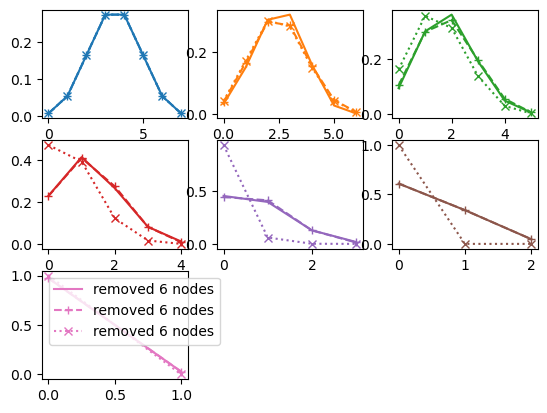

In [45]:
tab10 = list(mcolors.TABLEAU_COLORS.values())
p2 = p0
p_values = np.zeros((2,n))
for i in range(len(distributions)):
    plt.subplot(3,3,i+1)
    n = n0 - i
    # exact distribution
    plt.plot(distributions[i]/n, color=tab10[i], label=r'removed {} nodes'.format(i))
    # comparable binomial
    mean_k = np.sum(distributions[i]/n*np.arange(len(distributions[i])))
    #print('mean_k', mean_k)
    
    p = mean_k*n/2/binom(n,2)
    binomial_probs = binomialDistribution.pmf(np.arange(0, n), n-1, p)
    plt.plot(binomial_probs, '--', marker='+', color=tab10[i], label=r'removed {} nodes'.format(i))

    # comparable binomial with estimated kmax
    binomial_probs = binomialDistribution.pmf(np.arange(0, n), n-1, p2)
    plt.plot(binomial_probs, ':', marker='x', color=tab10[i], label=r'removed {} nodes'.format(i))
    print(r'{:.4f}, {:.4f}'.format(p, p2))

    p_values[0,i] = p
    p_values[1,i] = p2
    p2 = edgeProbabilityAfterTargetedAttack(n, p2)

plt.legend()

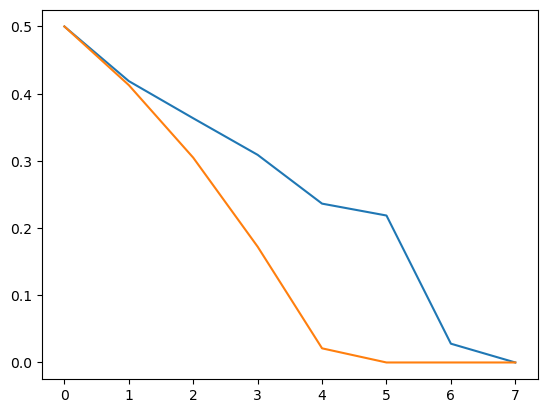

In [46]:
plt.plot(p_values[0])
plt.plot(p_values[1])